In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# from plotly.graph_objs import Figure, Histogram, Layout

In [2]:
pd.set_option('display.max_columns', 50)

# Creating the dataframes

In [5]:
countries = ['US', 'DE', 'CA', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
dframes = [code.lower()+'_df' for code in countries]

cat_ids = pd.read_csv('yt category list.csv', delimiter=' - ', engine='python')
for code, df in zip(countries, dframes):
    globals()[df] = pd.read_csv(f'{code}videos.csv', parse_dates=['trending_date', 'publish_time'], \
                                encoding_errors='ignore').merge(cat_ids, on='category_id', how='inner')\
                                .drop(['category_id', 'thumbnail_link'], axis=1)
    
us_df.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs


In [8]:
# we now have a dataframe for each of the countries
# we need to merge and identify the dataframes we've merged

df_list = []
for code, df in zip(countries, dframes):
    globals()[df]['country'] = code
    df_list.append(globals()[df])
    
df = pd.concat(df_list)
df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category,country
40737,UHIzVGIwH4g,18.14.06,"Деревня, которая не вымрет",varlamov,2018-06-13 14:18:05+00:00,"Голландия|""Нидерланды""|""Амстердам""|""каналы Амс...",62681,4196,51,759,False,False,False,"Сказочная Голландия! Пряничные домики, узкие у...",Travel & Events,RU
40738,9c-eJf_BcMw,18.02.01,Снежная королева 3. Огонь и лед,Три богатыря,2018-01-01 09:00:13+00:00,"Снежная королева|""Снежная королева 3""|""Снежная...",100049,1732,138,196,False,False,False,Редкий дар ввязываться во всевозможные неприят...,Movies,RU


# Cleaning up the raw data

In [10]:
# lets first remove some bias
# this will be videos with comments or ratings disabled
# this will also be videos with errors or has been removed

print(len(df))

df = df[~(df['comments_disabled'] | \
          df['ratings_disabled'] | \
          df['video_error_or_removed']) == True]

df = df.drop(['comments_disabled', 
              'ratings_disabled', 
              'video_error_or_removed'], axis=1)

375942


In [12]:
# lets also get rid of any null values, if existent
df = df.dropna()

In [13]:
# it also wouldn't be helpful to have nans in values later on
# so we'll remove any rows with int 0 in it
df = df.drop(df[df.isin([0]).any(axis = 1)].index)

In [15]:
# trending date is of type object, which is not valuable to us.
# lets make that a datetime object, then aggregate to find how long a video will take to trend

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['trending_delta'] = df['trending_date'] - df['publish_time'].dt.tz_localize(None)
df['trending_delta'] = df['trending_delta'].dt.days + 1
df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,US,3


In [18]:
# another thing we can do is extract the datetime from publish_time
df['hour'] = df['publish_time'].dt.hour
df['day'] = df['publish_time'].dt.day
df['week'] = df['publish_time'].dt.day_name()
df['month'] = df['publish_time'].dt.month_name()
df['year'] = df['publish_time'].dt.year
df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_pct,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,95.0,35,1411,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017,93.0,21,103,24.0,4


In [252]:
# it looks like we have barely any data for July - October
# Since we have almost no data for this, it's better to fully exclude these rows
# as we don't want to create false interpretations of it
df['month'].value_counts()

df = df[~df['publish_time'].dt.month.isin(range(7, 11))]

In [257]:
# now that we've cleaned up the dataframe, we should reset the index
df = df.reset_index().drop('index', axis=1)
df.tail(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_pct,len_title,len_desc,pct_cap,qty_tags
340287,UHIzVGIwH4g,2018-06-14,"Деревня, которая не вымрет",varlamov,2018-06-13 14:18:05+00:00,"Голландия|""Нидерланды""|""Амстердам""|""каналы Амс...",62681,4196,51,759,"Сказочная Голландия! Пряничные домики, узкие у...",Travel & Events,RU,1,14,13,Wednesday,June,2018,99.0,27,1364,NaN,25
340288,9c-eJf_BcMw,2018-01-02,Снежная королева 3. Огонь и лед,Три богатыря,2018-01-01 09:00:13+00:00,"Снежная королева|""Снежная королева 3""|""Снежная...",100049,1732,138,196,Редкий дар ввязываться во всевозможные неприят...,Movies,RU,1,9,1,Monday,January,2018,93.0,32,1310,NaN,16


# Analysis

In [17]:
# lets also mutate columns for better analysis

df['like_pct'] = 100 * round(df['likes'] / (df['likes'] + df['dislikes']), 2) # ratio of likes to dislikes
df['len_title'] = df['title'].str.findall(r'[.]*').str.len() # count chars in title
df['len_desc'] = df['description'].str.findall(r'[.]*').str.len() # count chars in desc
df['pct_cap'] = 100 * round(df['title'].str.findall(r'[A-Z]').str.len() /
                df['title'].str.findall(r'[A-Za-z]').str.len(), 2) # ratio of cap letters in title
df['qty_tags'] = df['tags'].str.split('|').str.len() # count number of tags

df.head(2)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_pct,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,95.0,35,1411,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017,93.0,21,103,24.0,4


## What is the main ingredient for a successful trending video?

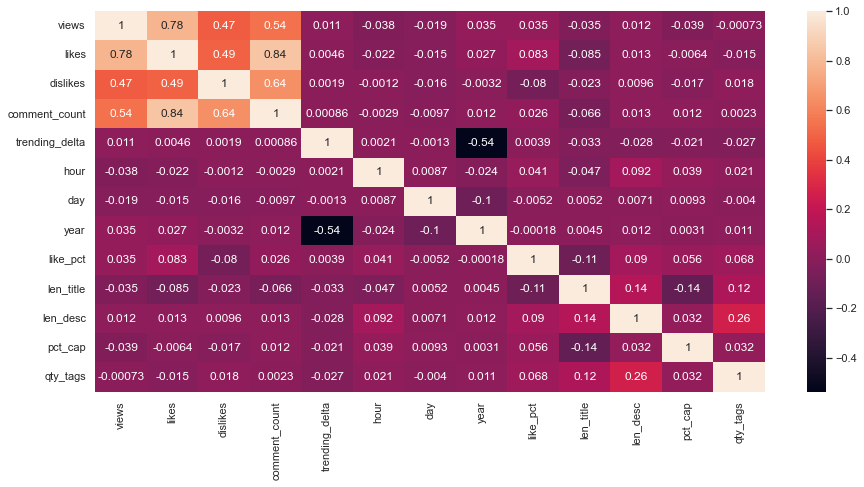

In [19]:
# lets create a correlation matrix with the base data and see what we get
sns.set(rc = {'figure.figsize':(15, 7)})
sns.heatmap(df.corr(), annot=True)
plt.show()

Text(0, 0.5, 'Dislikes')

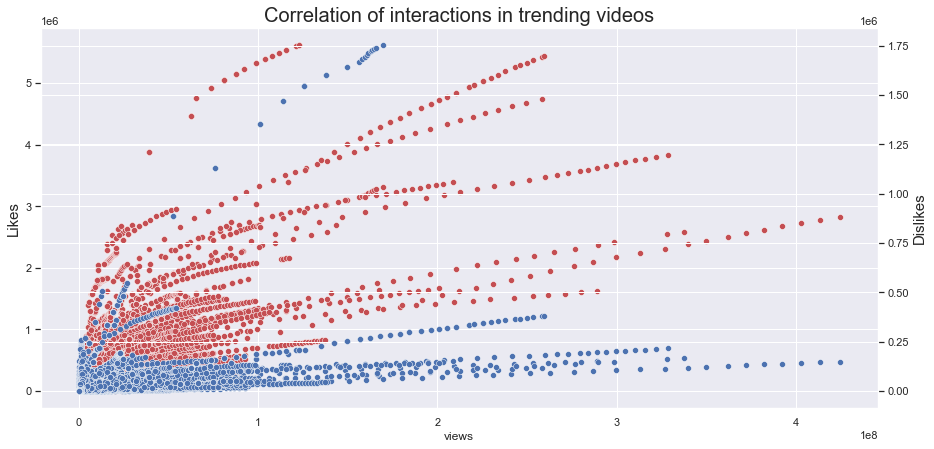

In [397]:
# as expected, we see a strong positive correlations between views and likes/dislikes

sns.scatterplot(x='views', y='likes', data=df, color = 'r')
plt.ylabel('Likes', fontsize = 15)
sns.scatterplot(x='views', y='dislikes', data=df, color = 'b', ax = plt.twinx())
plt.title('Correlation of interactions in trending videos', fontsize = 20)
plt.xlabel('Number of Views', fontsize = 15)
plt.ylabel('Dislikes', fontsize = 15)

Text(0, 0.5, 'Dislikes')

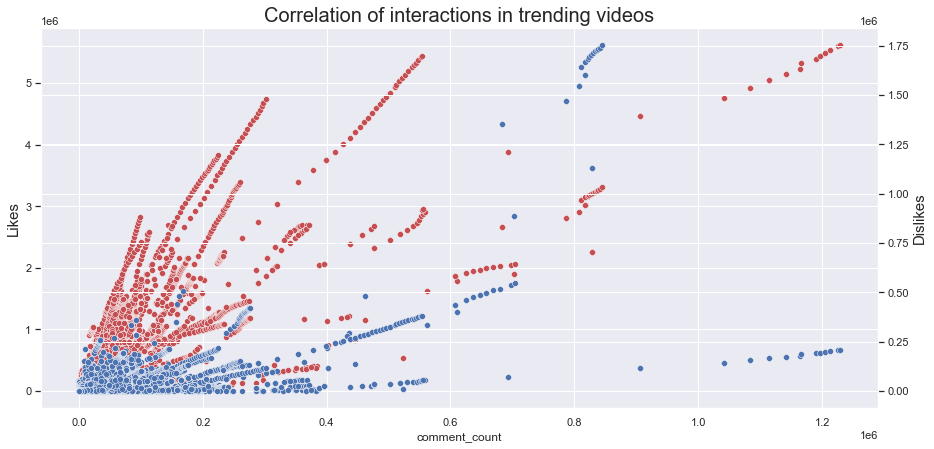

In [396]:
# there's also an obvious trend between the amount of likes/dislikes and the interactions (comments) people have

sns.scatterplot(x='comment_count', y='likes', data=df, color = 'r')
plt.ylabel('Likes', fontsize = 15)
sns.scatterplot(x='comment_count', y='dislikes', data=df, color = 'b', ax = plt.twinx())
plt.title('Correlation of interactions in trending videos', fontsize = 20)
plt.xlabel('Number of Comments', fontsize = 15)
plt.ylabel('Dislikes', fontsize = 15)

/Users/setone/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


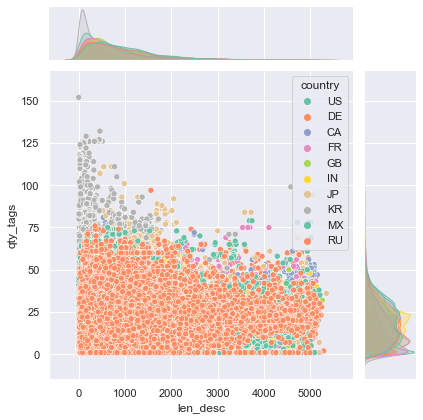

In [22]:
# there's also a correlation between the description length and qty. of tags
# which make sense, as creators who put in the time to write a lengthy description tend
# to also put in a good amount of tags to bring it viewers
sns.jointplot(x='len_desc', y='qty_tags', data=df, hue='country', palette='Set2')

Text(0, 0.5, 'Density')

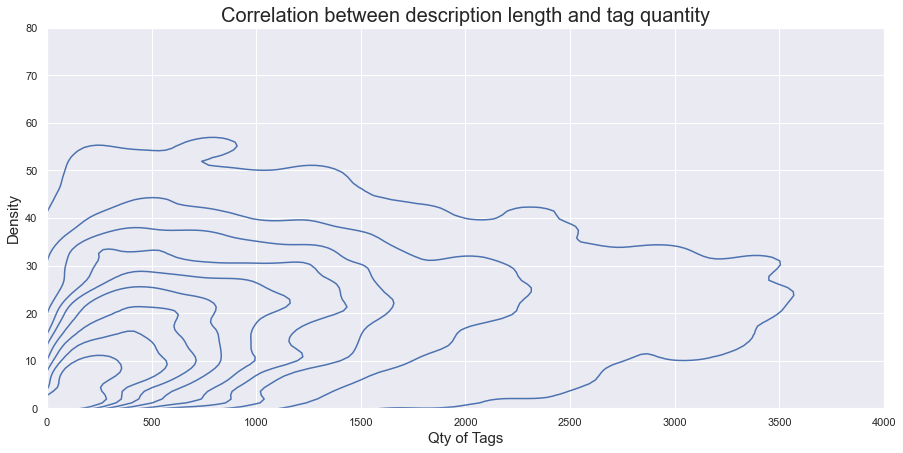

In [399]:
sns.kdeplot(x='len_desc', y='qty_tags', data=df, palette='Set2')
plt.xlim(0, 4000)
plt.ylim(0, 80)
plt.title('Correlation between description length and tag quantity', fontsize = 20)
plt.xlabel('Qty of Tags', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

## Let's group by category and perform some aggregations and analysis

Text(0, 0.5, 'Category')

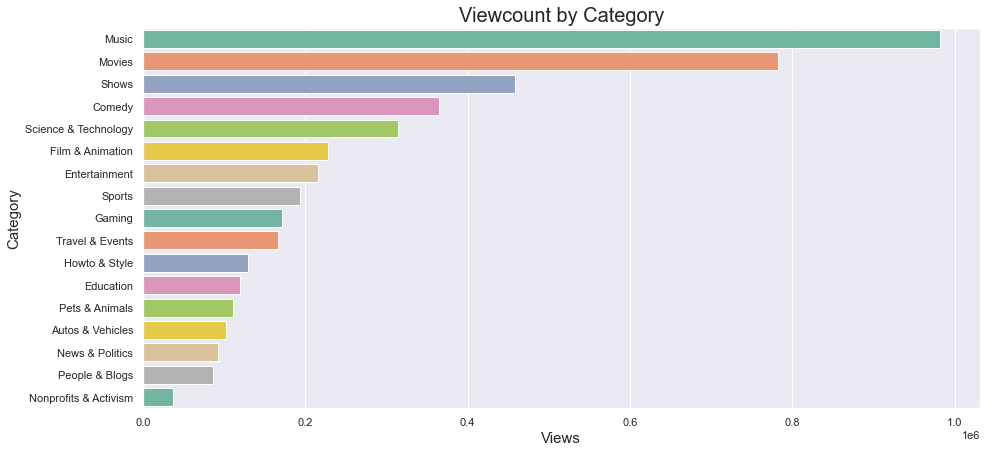

In [365]:
# we can group by categories and plot viewcount by its median
# as there are many outliers, the median tends to be a better metric than the mean

df2 = df.groupby('category').median().reset_index()
df2 = df2.sort_values('views', ascending=False)
sns.barplot(x='views', y='category', data = df2, palette = 'Set2')
plt.title('Viewcount by Category', fontsize = 20)
plt.xlabel('Views', fontsize = 15)
plt.ylabel('Category', fontsize = 15)

<AxesSubplot:xlabel='len_title', ylabel='category'>

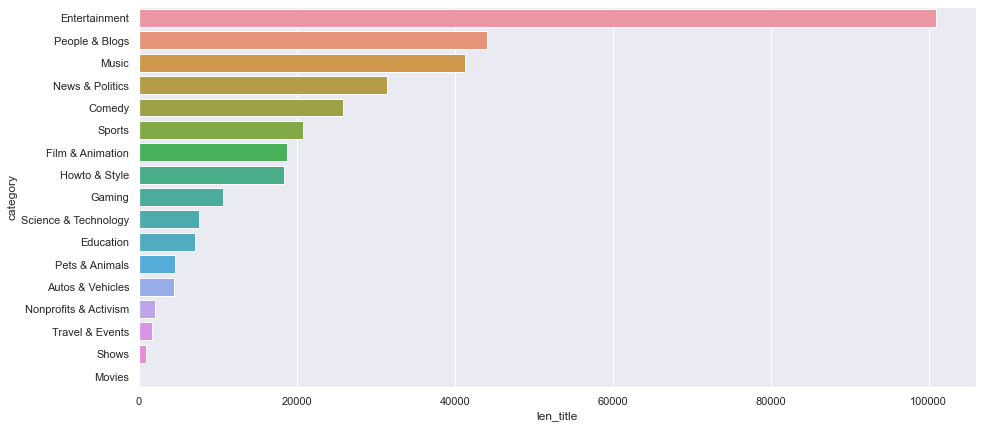

In [112]:
# we can also see how title length differ between categories

df3 = df.groupby('category').agg({'len_title': 'count'}).reset_index(
            ).sort_values('len_title', ascending=False)

sns.barplot(x = 'len_title', y = 'category', data = df3)

<AxesSubplot:xlabel='month', ylabel='views'>

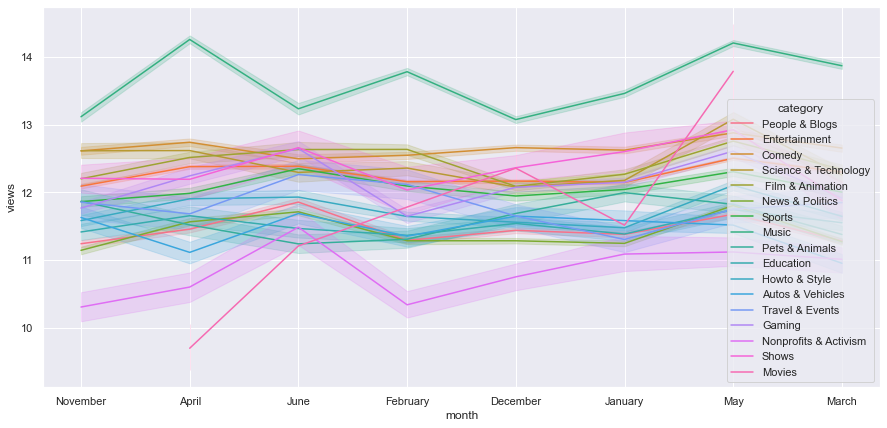

In [388]:
# does this change throughout the months?

sns.lineplot(x = 'month', y=np.log(df['views']), hue = 'category', data = df)

## Analyzing video metrics

In [ ]:
# from here, we can see that the average video title length is ~40-60 characters long
# with this information, we can make predictions on the attentive-ness of viewers

sns.histplot(x=df['len_title'], data=df, kde=True, bins=20)
plt.title('Title Length of Trending Videos', fontsize = 20)
plt.xlabel('Length of Title (characters)', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

Text(0, 0.5, 'Category')

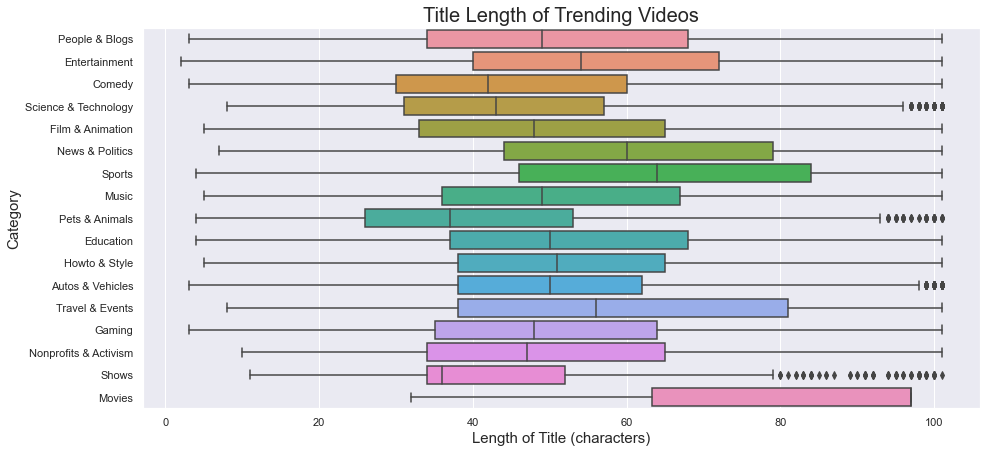

In [383]:
# however, we can see a more detailed view when we split the length by category
# it looks like the deviation sports and travel have the highest spread
# we can confirm that too by looking at the standard deviation values

sns.boxplot(x = 'len_title', y = 'category', data = df)
plt.title('Title Length of Trending Videos', fontsize = 20)
plt.xlabel('Length of Title (characters)', fontsize = 15)
plt.ylabel('Category', fontsize = 15)
# print(df.groupby('category').std()[['len_title']])

In [446]:
# we can now analyze the tags
# first, lets make a copy

df_tags = df.copy()
df_tags['tags'] = df_tags['tags'].apply(lambda x: x.split('|'))
df_tags.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,country,trending_delta,hour,day,week,month,year,like_pct,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,[SHANtell martin],748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,US,1,17,13,Monday,November,2017,95.0,35,1411,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"[cute, ""cats"", ""thai"", ""eggs""]",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,US,207,6,21,Friday,April,2017,93.0,21,103,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"[shawn johnson, ""andrew east"", ""shawn east"", ""...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,US,3,15,11,Saturday,November,2017,72.0,76,631,79.0,44


In [447]:
idx = 0
lst = []

for tag in df_tags['tags']:
    lst.extend(map(lambda x: [idx, x], tag))
    idx += 1
    
tags = pd.DataFrame(lst, columns = ['index', 'tags'])
tags['tags'] = tags['tags'].str.strip('""').str.lower()
tags.head(3)

,index,tags
0,0,shantell martin
1,1,cute
2,1,cats


In [448]:
df_tag = df_tags.drop('tags', axis = 1).merge(right = tags, how = 'right', 
                                               left_index = True, right_on = 'index')

In [451]:
df_tag['tags'].value_counts().head(15)

[none]           23887
funny            17071
comedy           15481
2018             10602
news              8256
music             8020
video             6374
trailer           5827
pop               5720
rap               5402
humor             5362
2017              5303
tv                5256
television        5044
entertainment     4841
Name: tags, dtype: int64

In [453]:
df_tag['tags'].value_counts().head(15)

top10_tags = ['funny', 'comedy', 'news', 'music', 'video', 
              'trailer', 'pop', 'rap', 'humor', 'tv']

df_tag = df_tag[df_tag['tags'].isin(top10_tags)]

## Energy usage

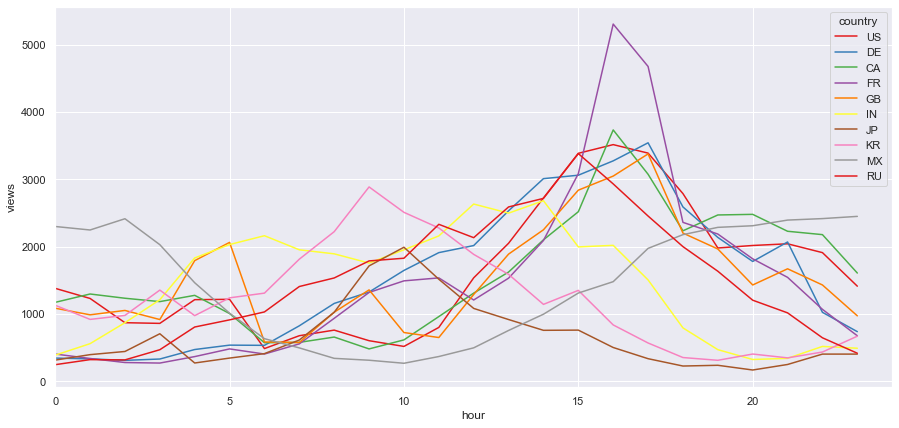

[(0.0, 24.0)]

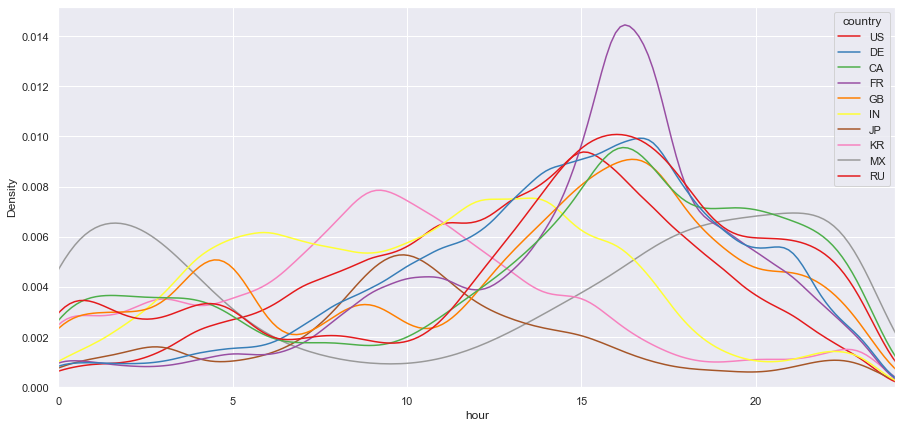

In [342]:
# as we can see, there's a prime correlation between viewership and content publish time.
# Since we'll be analyzing energy usage, I'll be taking advantage of this correlation
# by using publish time to pinpoint peak hours.

data = df.groupby(['country', 'hour']).agg({'views':'count'}).reset_index()
sns.lineplot(data=data, x='hour', y='views', hue='country', palette='Set1',
            hue_order=countries).set(xlim=(0, 24))
plt.show()

sns.kdeplot(data=df, x='hour', hue='country', palette='Set1').set(xlim=(0, 24))

Text(0, 0.5, 'Density')

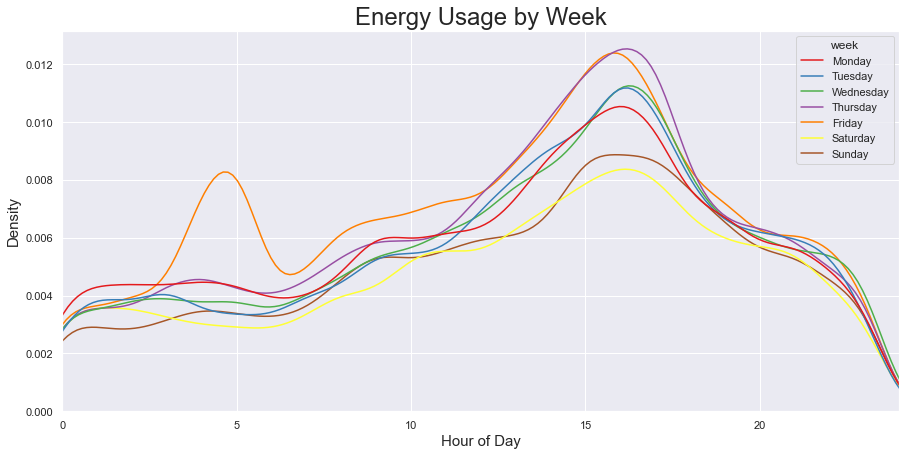

In [324]:
# based on the density plot, we can see peak hours throughout the week
# It feels fairly consistent throughout the mornings, with one exception.
# On Fridays, there seems to be a a massive peak right before 5AM.
# Additionally, the usage density triples from the morning to ~4PM.


sns.kdeplot(data = df, x = 'hour', hue = 'week', palette = 'Set1',
            hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 24)
plt.title('Energy Usage by Week', fontsize = 24)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

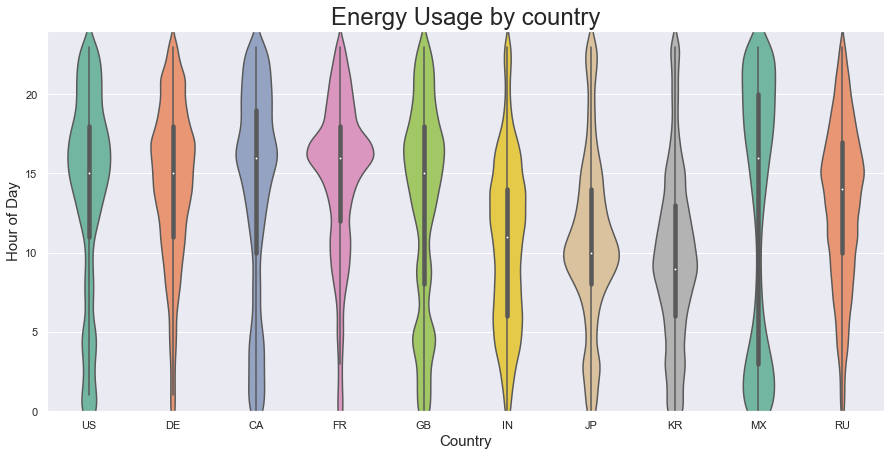

Text(0, 0.5, 'Density')

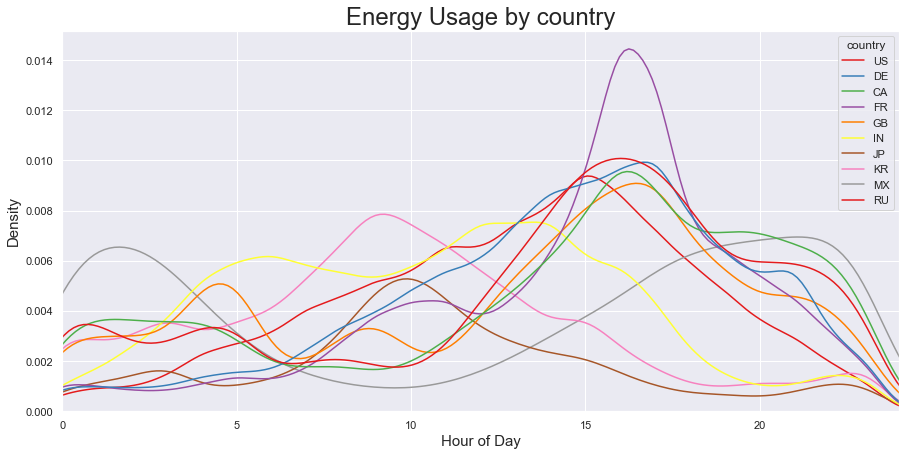

In [343]:
# however, we'd be foolish to think that all countries follow this trend.
# if we group by countries, we can see that the peak hours vary from one country to another

sns.violinplot(data=df, x='country', y='hour', palette='Set2').set(ylim=(0, 24))
plt.title('Energy Usage by country', fontsize = 24)
plt.xlabel('Country', fontsize = 15)
plt.ylabel('Hour of Day', fontsize = 15)
plt.show()

sns.kdeplot(data=df, x='hour', hue='country', palette='Set1').set(xlim=(0, 24))
plt.title('Energy Usage by country', fontsize = 24)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Density', fontsize = 15)


# usage in france is much higher than the rest of the world ~4PM
# the peak usage in Japan/Korea is ~9AM, whos countries are known for their nightlife
# Mexico peak hours start at 7PM and continues to the early AM
# usage in India is fairly consistent throughout the day, but takes a sharp decline ~8PM

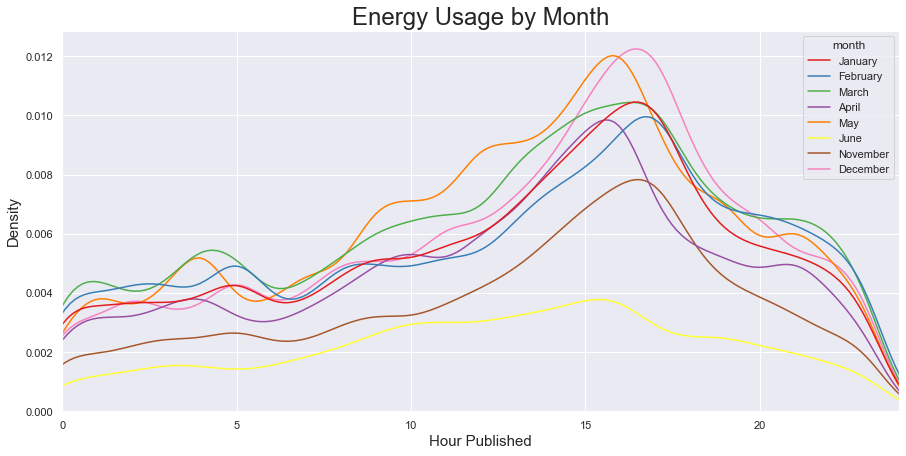

Text(0, 0.5, 'Count')

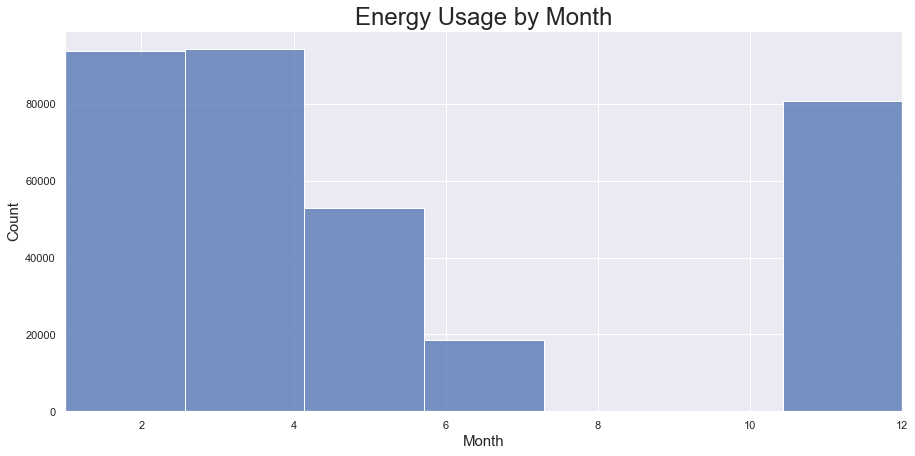

In [344]:
# another metric we can pay attention to would be how the trend continues by month
# unfortunately, the data we have contain months 7-10, which would be extremely valuable!
# it seems that during the summer months, the trend starts to die down.
# this is probably due to graduation and summer vacations
# If there were no missing data, I would expect that the trend would be a bit lower throughout the
# summer, and start picking back up in September

sns.kdeplot(data = df, x = 'hour', hue = 'month', palette = 'Set1',
           hue_order = ['January', 'February', 'March', 'April', 
                        'May', 'June', 'November', 'December'])
plt.xlim(0, 24)
plt.title('Energy Usage by Month', fontsize = 24)
plt.xlabel('Hour Published', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

sns.histplot(data = df, x = df['publish_time'].dt.month, palette='Set1', bins = 7)
plt.xlim(1, 12)
plt.title('Energy Usage by Month', fontsize = 24)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

Text(0, 0.5, 'Density')

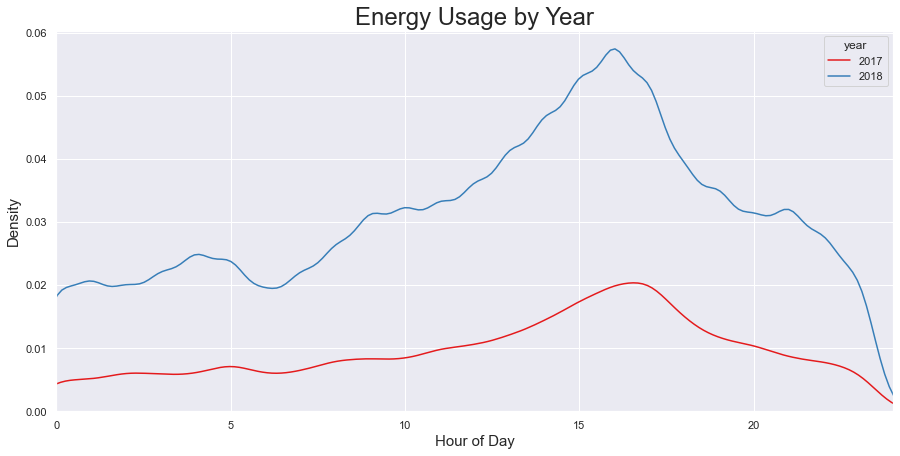

In [353]:
# we can view how usage grows throughout the years
# however, this may not necessarily be the best metric as we have incomplete data
# but this would allow us to understand how the company grows throughout the years

# since there isn't a lot of data before 2017, I've decided to exclude those years

sns.kdeplot(data = df[df['year'].isin([2017, 2018])], 
            x = 'hour', hue = 'year', palette = 'Set1')
plt.xlim(0, 24)
plt.title('Energy Usage by Year', fontsize = 24)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

Text(0, 0.5, 'Category')

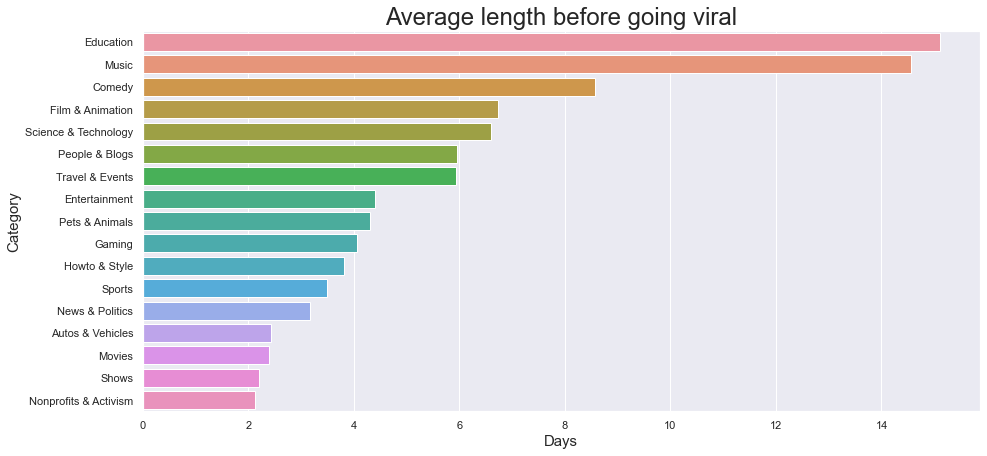

In [286]:
# another metric we can measure is the average length a video will take to trend, by category
# here we can see the music / education category take the prize, with ~15 days per video prior to trending
# this metric can tell us which categories people pay the most attention to
# and allow the company to devote resources towards certain categories

df4 = df.groupby('category').mean().sort_values('trending_delta', ascending=False).reset_index()
sns.barplot(data=df4, y='category', x='trending_delta')
plt.title('Average length before going viral', fontsize = 24)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Category', fontsize = 15)

In [ ]:
b = df.groupby('category').agg(['mean', 'std', 'sum', 'median'])
sns.heatmap(b.corr())
plt.show()

In [ ]:
a = df.groupby('category').agg({'category':['count'], \
                            'views': ['mean', 'std', 'sum'], \
                            'likes': ['mean', 'std', 'sum'], \
                            'dislikes': ['mean', 'std', 'sum']})

sns.heatmap(a.corr(), annot=True)
plt.show()

In [ ]:
df['trending_date'].dt.weekday,

In [ ]:
# lets first see how much of each category there is

df5 = df.groupby('category').agg(count=('category', 'count'),
                           views=('views', 'mean'), 
                           likes=('like_pct', 'mean')
                          ).sort_values(by='count', ascending=False).reset_index()

sns.barplot(x='category', y='count', data=df5, hue = df5)
plt.xticks(rotation=90)

In [ ]:
df5.head(3)

In [ ]:
sns.histplot(x='like_pct', data=df, kde=True, log_scale=[False, True])

In [ ]:
df3 = df.groupby('category').mean().reset_index().sort_values('pct_cap', ascending=False)
sns.barplot(x='category', y='pct_cap', data=df3)
plt.xticks(rotation=90)

In [ ]:
sns.scatterplot(x='len_title', y='like_pct', data=df, alpha=0.5)

In [ ]:
# the length of the description tends to skew to the left
# this may not necessarily mean that videos that write more tend to fail less
# it's of
sns.histplot(x='len_desc', data=df, kde=True)

In [ ]:
sns.histplot(data=df, x=df['trending_date'].dt.month, kde=True)

In [ ]:
# lets take a look at the trending data
print(f"min: {df['trending_date'].dt.date.min().month} \
        max: {df['trending_date'].dt.date.max().month}")

# we unfortunately don't have a full complete year of trending data to analyze
sns.distplot(df['trending_date'].dt.month, )
# it would be extremely interesting to see, but it looks like more videos trend during the holidays
# and trends the least during the summer, which makes sense
# hopefully other countries have the data to fill in the gap

In [ ]:
sns.histplot(df['publish_hour'], bins=20, kde=True)

In [ ]:
# but based on what we have, we can at least take the statistics to see active user counts
# it looks like videos are likely to trend around noon, with the highest peak ~4pm
# this makes sense as people are checking off work
sns.histplot(df['publish_time'].dt.hour, kde=True)

In [ ]:
df.head(3)

In [ ]:
sns.boxplot(x=df['trending_delta'].dt.days, data=df)

In [ ]:
df4 = df.copy()
df4['trending_delta'] = df4['trending_delta'].dt.days
df4 = df4.groupby('category').mean().sort_values('trending_delta', ascending=False).reset_index()
df4.head(3)

In [ ]:
sns.barplot(x='category', y='trending_delta', data=df4)
plt.xticks(rotation=90)

In [ ]:
plt.hist(df['trending_delta'].dt.days, range=(1, 20))
plt.xlabel('# of days before viral')
plt.ylabel('videos')
plt.title('')